setup code goes here

In [1]:
import os
import shutil
import asyncio
import tempfile
import threading
import contextlib

import unittest.mock as mock

import synapse.glob as s_glob
import synapse.common as s_common
import synapse.cortex as s_cortex
# import synapse.lib.cli as s_cli
import synapse.lib.cmdr as s_cmdr

import synapse.tests.utils as s_t_utils
# print(f'Current pid: {os.getpid()}')
current_thread = threading.current_thread()
# print(f'Current thread / thread.ident: {current_thread}')
# print(type(current_thread))
loop = s_glob.initloop()
# print(f'Current loop: {loop} / {id(loop)}')
glob_thrd = s_glob._glob_thrd
# print(f'loop thread: {glob_thrd}')

@contextlib.asynccontextmanager
async def getTempCoreProxy():
    with s_common.getTempDir() as dirn:
        # print(f'Got tempdir: {dirn}')
        # print('getting cortex....')
        async with await s_cortex.Cortex.anit(dirn) as core:
            # print(f'Got cortex: {core}')
            # print('Getting local proxy')
            # core.conf['storm:log'] = True
            async with core.getLocalProxy() as prox:
                # print(f'Got proxy: {prox}')
                yield prox
                # print('closing down proxy/local dmon')
            # print('closing down cortex')
        # print('tearing down tempdir')
    # print('done with getTempCortex')

acm = getTempCoreProxy()
core = await acm.__aenter__()
# print(proxy, proxy.isfini)

# print('preloading some data...')
q = '[inet:ipv4=1.2.3.4 inet:ipv4=8.8.8.8 inet:ipv4=12.34.56.78 inet:fqdn=woot.com]'
async for mesg in await core.storm(q):
    pass
    #print(mesg)
    
cmdr = await s_cmdr.getItemCmdr(core)
cmdr.echoline = True
# print(f'Got cmdr: {cmdr}')

Execute a storm command!

In [2]:
await cmdr.runCmdLine('storm inet:ipv4')
# cmdr.runCmdLoop()
# await cmdr.asyncRunCmdLoop()

cli> storm inet:ipv4

inet:ipv4=1.2.3.4
        .created = 2018/12/10 13:49:38.618
        :asn = 0
        :loc = ??
        :type = unicast
inet:ipv4=8.8.8.8
        .created = 2018/12/10 13:49:38.619
        :asn = 0
        :loc = ??
        :type = unicast
inet:ipv4=12.34.56.78
        .created = 2018/12/10 13:49:38.619
        :asn = 0
        :loc = ??
        :type = unicast
complete. 3 nodes in 4 ms (750/sec).


See how cool that was!

# Storm Reference - Data Modification

Storm can be used to directly modify the Synapse hypergraph by:

* adding or deleting nodes;
* setting, modifying, or deleting properties on nodes; and 
* adding or deleting tags from nodes.

While the Synapse command line (cmdr) is not optimal for adding or modifying large amounts of data, users gain a powerful degree of flexibility and efficiency through the ability to create or modify data on the fly.

For adding or modifying larger amounts of data, it is preferable to use the Synapse feed utility <link>, CSV tool <link>, or programmatic ingest of data to help automate the process.

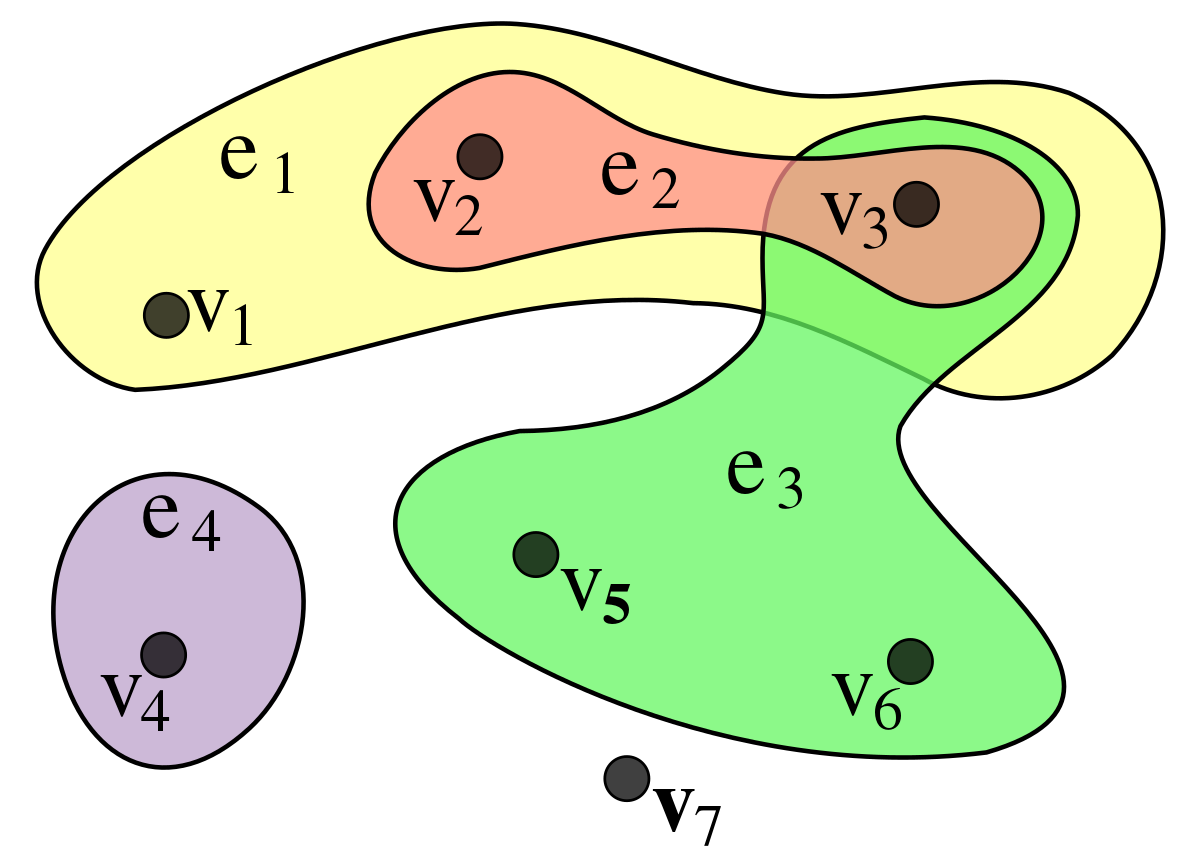


<div class="alert alert-block alert-warning">
<b>WARNING</b>
The ability to add and modify data from the Synapse CLI is powerful and convenient, but also means users can inadvertently modify (or even delete) data inappropriately through mistyped syntax or premature striking of the “enter” key. While some built-in protections exist within Synapse itself it is important to remember that <b>there is no “are you sure?” prompt before a Storm query executes<b>.

The following recommended “best practices” will help prevent inadvertent changes to the hypergraph:

Use the Synapse permissions system <link> to enforce least privilege. Limit users to permissions appropriate for tasks they have been trained for / are responsible for.

Limit potentially destructive permissions even for trained / trusted users. Require the use of the sudo <link> Storm command for significant / critical changes (such as the deletion of nodes).

Use extreme caution when constructing complex Storm queries that may modify (or delete) large numbers of nodes. It is <b>strongly recommended<b> that you validate the output of a query by first running the query on its own to ensure it returns the expected results (set of nodes) before permanently modifying (or deleting) those nodes.
</div>

See Storm - Document Syntax Conventions <link> for an explanation of the syntax format used below.

## Edit Mode

To modify data in a Cortex using Storm, you must enter “edit mode”. The use of **square brackets ( \[ \] )** within a Storm query can be thought of as entering “edit mode”, with the data in the brackets specifying the changes to be made. This is true for changes involving nodes, properties, and tags. The only exception is the deletion of nodes, which is done using the **delnode** <link> Storm command.

The square brackets (\[ \]) used for the Storm data modification syntax indicate “perform the enclosed changes” in a generic way. The brackets are shorthand to request any of the following:

* Add nodes.
* Add or modify properties.
* Delete properties.
* Add tags.
* Delete tags.

This means that all of the above directives can be specified within a single set of brackets, in any combination and in any order.

<div class="alert alert-block alert-warning">
<b>WARNING</b>
It is critical to remember that the </b>brackets are NOT a boundary that segregates nodes</b>; they simply indicate the start and end of data modification operations. They do </b>NOT</b> separate “nodes the modifications should apply to” from “nodes they should not apply to”. Storm operator chaining <link> with left-to-right processing order still applies. </b>Any modification request that operates on previous Storm output will operate on everything to the left of the modify operation, regardless of whether those nodes are within or outside the brackets</b>v.
</div>

Consider the following example:

In [3]:
q = 'storm inet:ipv4=12.34.56.78 inet:fqdn=woot.com [ inet:ipv4=1.2.3.4 :asn=10101 inet:fqdn=woowoo.com +#my.tag ]'
await cmdr.runCmdLine(q)
# Assertion code about the output - woudl fail during execution
podes = [pode async for pode in await core.eval('#my.tag')]
# assert len(podes) == 4
print('hmmm')

Error during storm execution
Traceback (most recent call last):
  File "/home/epiphyte/git/synapse/synapse/cortex.py", line 1010, in runStorm
    async for pode in snap.iterStormPodes(text, opts=opts, user=user):
  File "/home/epiphyte/git/synapse/synapse/lib/snap.py", line 101, in iterStormPodes
    async for node, path in self.storm(text, opts=opts, user=user):
  File "/home/epiphyte/git/synapse/synapse/lib/snap.py", line 113, in storm
    async for x in runt.iterStormQuery(query):
  File "/home/epiphyte/git/synapse/synapse/lib/storm.py", line 130, in iterStormQuery
    async for node, path in query.iterNodePaths(self):
  File "/home/epiphyte/git/synapse/synapse/lib/ast.py", line 173, in iterNodePaths
    async for node, path in genr:
  File "/home/epiphyte/git/synapse/synapse/lib/ast.py", line 1589, in run
    async for node, path in genr:
  File "/home/epiphyte/git/synapse/synapse/lib/ast.py", line 1513, in run
    async for node, path in genr:
  File "/home/epiphyte/git/synapse/sy

cli> storm inet:ipv4=12.34.56.78 inet:fqdn=woot.com [ inet:ipv4=1.2.3.4 :asn=10101 inet:fqdn=woowoo.com +#my.tag ]

('prop:set', {'ndef': ('inet:ipv4', 203569230), 'prop': 'asn', 'valu': 10101, 'oldv': 0, 'user': '?', 'time': 1544449786654})
('node:add', {'ndef': ('inet:asn', 10101), 'user': '?', 'time': 1544449786655})
('prop:set', {'ndef': ('inet:asn', 10101), 'prop': 'name', 'valu': '??', 'oldv': None, 'user': '?', 'time': 1544449786655})
('prop:set', {'ndef': ('inet:asn', 10101), 'prop': '.created', 'valu': 1544449786655, 'oldv': None, 'user': '?', 'time': 1544449786655})
('node:add', {'ndef': ('syn:tag', 'my.tag'), 'user': '?', 'time': 1544449786655})
('prop:set', {'ndef': ('syn:tag', 'my.tag'), 'prop': 'base', 'valu': 'tag', 'oldv': None, 'user': '?', 'time': 1544449786656})
('prop:set', {'ndef': ('syn:tag', 'my.tag'), 'prop': 'depth', 'valu': 1, 'oldv': None, 'user': '?', 'time': 1544449786656})
('prop:set', {'ndef': ('syn:tag', 'my.tag'), 'prop': 'up', 'valu': 'my', 'oldv': Non

The above Storm query will:
* lift the nodes for IP 12.34.56.78 and domain woot.com;
* create the node for IP 1.2.3.4 (if it does not exist), or retrieve it if it does;
* set the :asn property for IP 12.34.56.78 and IP 1.2.3.4;
* create the node for domain woowoo.com (if it does not exist), or retrieve it if it does; and
* apply the tag my.tag to IP 12.34.56.78, domain woot.com, IP 1.2.3.4 and domain woowoo.com.


In [4]:
cmdr.fini()
await acm.__aexit__(None, None, None)
# print(proxy, proxy.isfini)#
    